# Final Assignment - AccessViz - AutoGIS 2018 
##### Name: Ella Rauth 
##### Student ID: 014964527

## Importing Packages and Data

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import folium 
import numpy as np # needed???
import matplotlib.pyplot as plt
import os.path

In [2]:
# reading the grid file
grid = gpd.read_file('data/MetropAccess_YKR_grid/MetropAccess_YKR_grid_EurefFIN.shp')

# saving the YKR_IDs in grid as a list
ykr_ids = list(grid.YKR_ID)

In [4]:
# global variables for storing the output of the user defined input
# by default data is appended to the lists, but can also be cleared manually with clear_all()

valid_ids = [] # list of valid YKR-IDs specified by the user
ttmats = [] # list of travel time matrices corresponding to the valid ids
joined_ttmats = [] # list of travel time matrices that have been joined with the grid

# function for clearing the valid_ids, ttmats, and joined_ttmats lists
def clear_all():
    valid_ids.clear()
    ttmats.clear()
    joined_ttmats.clear()

In [5]:
# function for reading the travel time matrix of a specified year and YKR_ID
def read_ttmat(year, ykr_id):
    # reading the travel time matrix
    ttmat = pd.read_csv('data/HelsinkiRegion_TravelTimeMatrix'+str(year)+'/travel_times_to_ '+str(ykr_id)+'.txt', sep=';')
    
    # converting the ttmat dataframe to a geodataframe
    ttmat = gpd.GeoDataFrame(ttmat)
    
    # setting the crs to that of the grid geodataframe
    ttmat.crs = grid.crs
    
    return ttmat

## NoData Values
Notice that there are NoData values present in the data (value -1). In such cases the result cell should always end up having a value -1 when doing travel mode comparisons. In the visualizations, the NoData values should be removed before visualizing the map.

## Functionality 1
AccessViz finds from the data folder all the matrices that user has specified by assigning a list of integer values that should correspond to YKR-IDs found from the attribute table of a Shapefile called MetropAccess_YKR_grid.shp. If the ID-number that the user has specified does not exist in the data folders, the tools should warn about this to the user but still continue running. The tool should also inform the user about the execution process: tell the user what file is currently under process and how many files there are left (e.g. “Processing file travel_times_to_5797076.txt.. Progress: 3/25”).

In [6]:
# function for loading the travel time matrices for a set of YKR_IDs that were specified by the user
# by default the most recent data (from 2018) is used, but the user can specify which year to use
def load_ttmats(input_ids, year=2018):    
    # intitializing a counter for processed ids
    done = 0
    
    # matching the input_ids with the ykr_ids and loading the corresponding travel time matrices
    for i in input_ids:
        # incrementing the counter of processed ids
        done += 1
        
        if i in ykr_ids: # the current id is a valid YKR-ID
            if i not in valid_ids: # the current id has not yet been processed
                # adding the current id to the list of valid ids
                valid_ids.append(i)

                # loading the file corresponding to the id and adding it to the ttmats list
                ttmats.append(read_ttmat(year, i))
            
            # informing the user about the progress
            print('STATUS:\t Loaded file travel_times_to_'+str(i)+'.txt from year', year,
                  'Progress:', str(done)+'/'+str(len(input_ids))+' IDs processed')
            
        else: # the current id is not a valid YKR-ID
            # informing the user about the progress
            print('WARNING:', i, 'is not a valid YKR-ID', 
                  '\t\t\t\tProgress:', str(done)+'/'+str(len(input_ids))+' IDs processed')           

In [22]:
# user defined list of YKR_IDs
input_ids = [5785642, 5785644, 5793269]

# user defined year to get data from (2013, 2015, 2018)
year = 2013

# loading the travel time matrices for the above specified input
load_ttmats(input_ids, year)

STATUS:	 Loaded file travel_times_to_5785642.txt from year 2013 Progress: 1/3 IDs processed
STATUS:	 Loaded file travel_times_to_5793269.txt from year 2013 Progress: 3/3 IDs processed


## Functionality 2

AccessViz can create Shapefiles from the chosen Matrix text tables (e.g. travel_times_to_5797076.txt) by joining the Matrix file with MetropAccess_YKR_grid Shapefile where from_id in Matrix file corresponds to YKR_ID in the Shapefile. The tool saves the result in the output-folder that user has defined. You should name the files in a way that it is possible to identify the ID from the name (e.g. 5797076).

In [28]:
# function for processing the travel time matrices for the valid ids
def join_ttmats(output_folder):
    # check if the specified output folder exists
    if not os.path.isdir(output_folder):
        # if the folder does not exist, create it
        os.makedirs(output_folder)
    
    # joining each ttmat with the grid 
    for i in range(len(valid_ids)):
        # checking if the join result has already been calculated
        if len(valid_ids) != len(joined_ttmats):
            # joining the current travel time matrix with the grid file on from_id and YKR_ID
            joined_ttmats.append(ttmats[i].merge(grid, left_on='from_id', right_on='YKR_ID'))

        # creating the file name
        output_file_name = output_folder + '/travel_times_to_' + str(valid_ids[i]) + '.shp'
        
        # checking if the file has already been saved
        if not os.path.isfile(output_file_name):
            # saving the file
            joined_ttmats[i].to_file(output_file_name)

In [29]:
# specifying the output folder
output_folder = 'output_join'

# joining the previously loaded travel time matrices with the grid file
join_ttmats(output_folder)

## Functionality 3

AccessViz can visualize the travel times of selected YKR_IDs based on the travel mode that the user specifies. It can save those maps into a folder that user specifies. The output maps can be either static or interactive and user can choose which one with a parameter. You can freely design yourself the style of the map, colors, travel time intervals (classes) etc. Try to make the map as informative as possible!

In [106]:
# function for visualizing travel times of the selected travel time matrices, 
# given a travel mode (walk, pt or car), a map type (static or interactive), and an output folder name
def visualize_ttmats(travel_mode, map_type, output_folder):
    # assert that the travel mode an map type are valid
    assert travel_mode in ['walk', 'pt', 'car'], 'Please select a valid travel mode! (walk, pt, car)'
    assert map_type in ['static', 'interactive'], 'Please select a valid map type! (static, interactive)'
    
    # check if the specified output folder exists
    if not os.path.isdir(output_folder):
        # if the folder does not exist, create it
        os.makedirs(output_folder)
        
    # creating the name of the travel mode column
    travel_mode = travel_mode+'_m_t'
    
    for i in range(len(valid_ids)):
        # saving the current travel time matrix in a new variable
        ttmat = joined_ttmats[i]
        
        # removing rows with missing values in the travel mode column
        ttmat = ttmat[ttmat[travel_mode] != -1]
        
        if map_type == 'static': # the user specific 'static' as the map type
            # reprojecting the ttmat
            ttmat = ttmat.to_crs(epsg=3857)

            # creating the map
            ttmat_map = ttmat.plot(column=travel_mode, cmap='RdYlBu', alpha=0.85);
            
            # adding a basemap
            ctx.add_basemap(ttmat_map)
            
            # creating a figure out of the plot
            ttmat_map = ttmat_map.get_figure()
            
            # setting the size of the figure
            ttmat_map.set_size_inches(15, 15)
            
            # saving the map in the specified folder
            ttmat_map.savefig(output_folder+'/travel_times_to_'+str(valid_ids[i])+'_'+travel_mode+'.png')
        
        else: # the user specific 'interactive' as the map type
            # reprojecting the ttmat
            ttmat = ttmat.to_crs(epsg=4326)
                        
            # creating a geoid column for folium
            ttmat['geoid'] = ttmat.index.astype(str)
            
            # dropping all unneccesary columns
            ttmat = ttmat[['geoid', travel_mode, 'geometry']]

            # creating a folium map with initial focus on Helsinki
            ttmat_map = folium.Map(location=[60.25, 24.8], zoom_start=10, control_scale=True)

            # adding a choropleth layer of the travel times
            ttmat_map.choropleth(geo_data=ttmat.to_json(), data=ttmat, columns=['geoid', travel_mode],
                                 key_on='feature.id', fill_color='YlOrRd', fill_opacity=0.7, line_weight=0)

            ttmat_map.save(output_folder+'/travel_times_to_'+str(valid_ids[i])+'_'+travel_mode+'.html')        

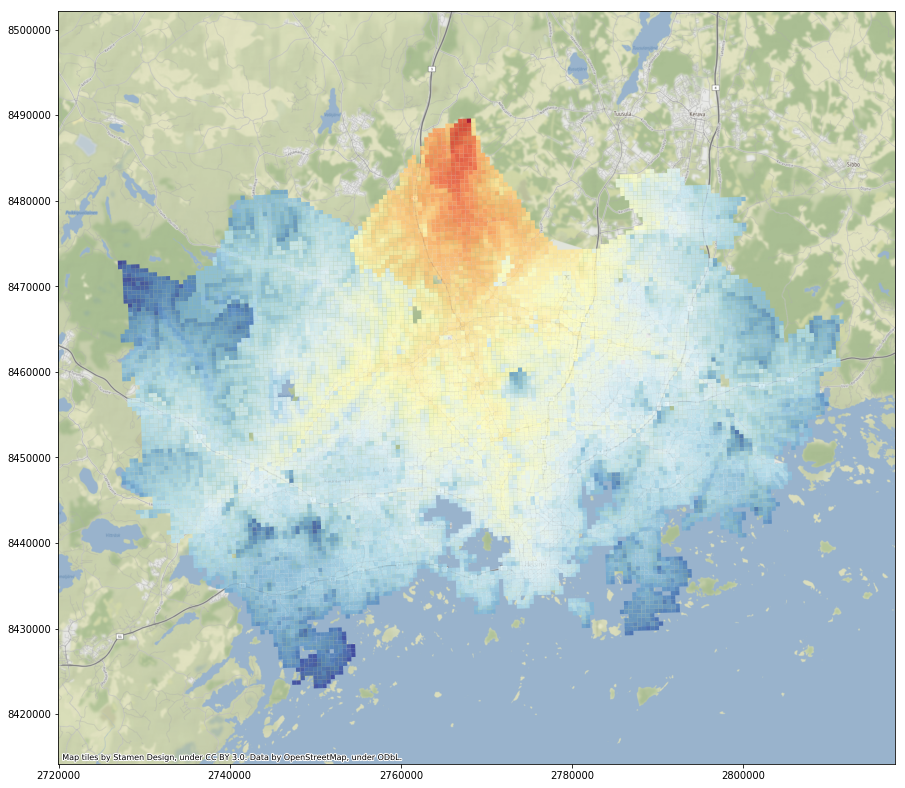

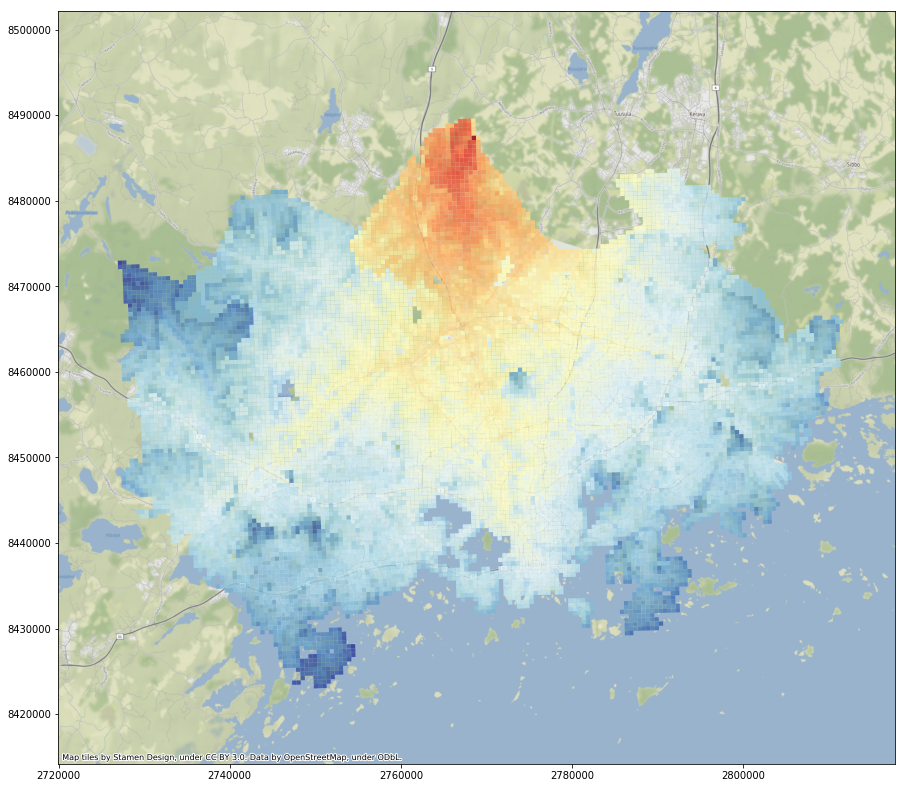

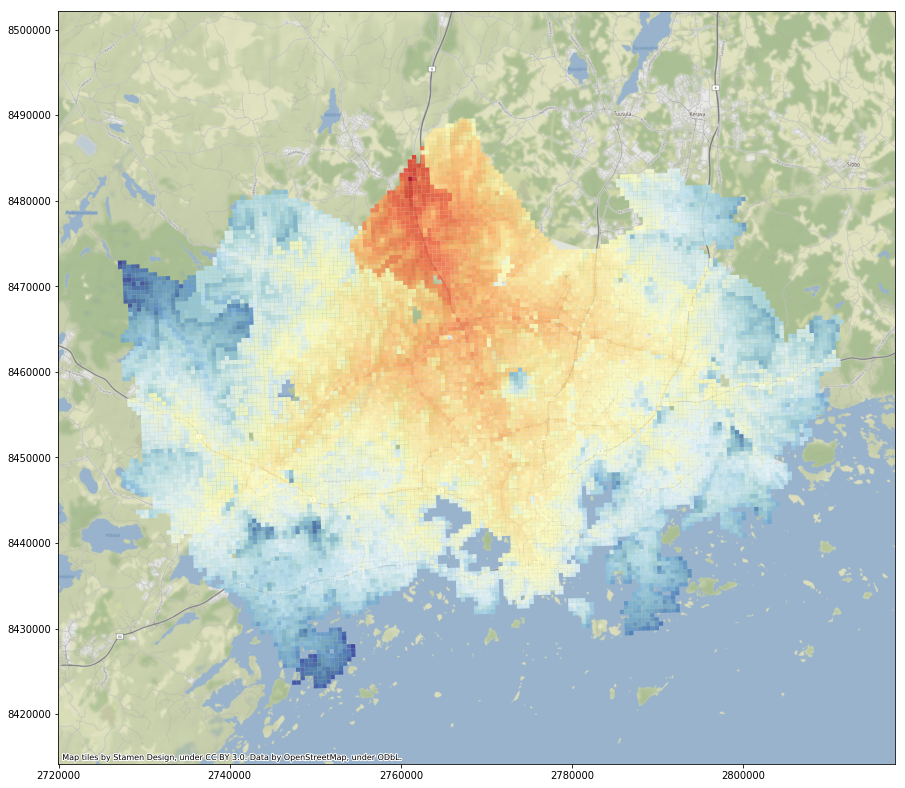

In [107]:
# selecting a travel mode from: 'walk', 'pt', and 'car'
travel_mode = 'car' # test pt

# selecting a map type from: 'static', 'interactive'
map_type = 'static'

# selecting an output folder
output_folder = 'output_map'

visualize_ttmats(travel_mode, map_type, output_folder) # prints maps....

In [101]:
joined_ttmats[0].head()

,from_id,to_id,walk_t,walk_d,pt_m_tt,pt_m_t,pt_m_d,car_m_t,car_m_d,x,y,YKR_ID,geometry
0,5785640,5785642,50,3470,50,50,3470,12,1324,381875.0,6697880.0,5785640,"POLYGON ((382000.0001388059 6697750.000128186,..."
1,5785641,5785642,53,3676,53,53,3676,12,1184,382125.0,6697880.0,5785641,"POLYGON ((382250.00013875 6697750.000128181, 3..."
2,5785642,5785642,0,0,0,0,0,0,0,382375.0,6697880.0,5785642,"POLYGON ((382500.0001386951 6697750.000128172,..."
3,5785643,5785642,58,4087,58,58,4087,36,15775,382625.0,6697880.0,5785643,"POLYGON ((382750.0001386406 6697750.000128165,..."
4,5787544,5785642,43,2981,43,43,2981,28,9326,381125.0,6697630.0,5787544,"POLYGON ((381250.000138978 6697500.000128254, ..."


## Functionality 4

AccessViz can also compare travel times or travel distances between two different travel modes (more than two travel modes are not allowed). Thus IF the user has specified two travel modes (passed in as a list) for the AccessViz, the tool will calculate the time/distance difference of those travel modes into a new data column that should be created in the Shapefile. The logic of the calculation is following the order of the items passed on the list where first travel mode is always subtracted by the last one: travelmode1 - travelmode2. The tool should ensure that distances are not compared to travel times and vice versa. If the user chooses to compare travel modes to each other, you should add the travel modes to the filename such as Accessibility_5797076_pt_vs_car.shp. If the user has not specified any travel modes, the tool should only create the Shapefile but not execute any calculations. It should be only possible to compare two travel modes between each other at the time. Accepted travel modes are the same ones that are found in the actual TravelTimeMatrix file (pt_r_tt, car_t, etc.). If the user specifies something else, stop the program, and give advice what are the acceptable values.

## Functionality 5

(option 1). Bundled with AccessViz there is also a separate interactive map that shows the YKR grid values in Helsinki region. The purpose of the map is to help the user to choose the YKR-IDs that s/he is interested to visualize / analyze.

## Functionality 6

(option 2). AccessViz can also visualize the travel mode comparisons that were described in step 4. You can design the style of the map yourself, but try to make it as informative as possible!

## Functionality 7

(option 3). AccessViz can also visualize shortest path routes (walking, cycling, and/or driving) using OpenStreetMap data from Helsinki Region. The impedance value for the routes can be distance (as was shown in Lesson 7) or time (optional for the most advanced students). This functionality can also be a separate program (it is not required to bundle include this with the rest of the AccessViz tool)